<a href="https://colab.research.google.com/github/Marlrero/AI_PrimaryEducation/blob/main/speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Keras CNN과 RNN(GRU)으로 음성 인식

#### 1. import packages & set hyperparameters

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # One-hot encoding
from keras.layers import BatchNormalization, Bidirectional, Conv1D, Dense, \
                         Dropout, GRU, Input, MaxPooling1D
from keras.models import Model

from tqdm import tqdm
import librosa
import librosa.display

In [2]:
# hyperparameters
MY_SPLIT = 0.8
MY_HIDDEN = 128
MY_DROP = 0.3    # dropout
MY_BATCH = 128
MY_EPOCH = 100
MY_PATH = '/content/drive/MyDrive/dataset/audio'

# mode selection
READ_WAV = 0 #1
TRAIN_MODE = 1

#### 2. load dataset & data preprocessing

[ 0.00045734  0.00092356  0.00115384 ...  0.00073417 -0.00068279
 -0.0008395 ] 22050 22050


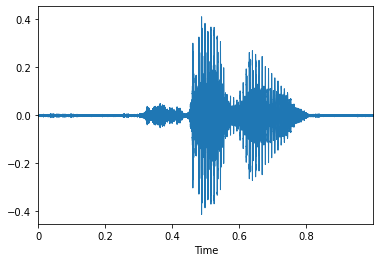

In [3]:
# 5가지 음성 라벨
labels = ['go', 'happy', 'seven', 'stop', 'yes']

# sample autio file
# y: sampling data, sr: sampling rate
y, sr = librosa.load('/content/drive/MyDrive/dataset/test.wav')
print(y, len(y), sr) # 22.05 kHz
librosa.display.waveplot(y, sr=sr)

In [4]:
# 오디오 파일 읽고 처리
def read_wave():
  begin = time()
  print("Resampling start...")
  # 자연어 처리(기사 카테고리 분류)에서는 pad_sequences를 사용했었음
  # 이는 뒤나 앞을 0으로 채우기 때문에 이는 안좋은 방법!
  all_wave = []
  all_label = []

  # tqdm 함수는 진행 사항을 표시하기 위함
  for label in tqdm(labels):
    path = MY_PATH + '/' + label # 5가지 음성 라벨 폴더 경로
    waves = [f for f in os.listdir(path)]

    for wav in waves:
      # 1개의 오디오 파일을 16kHz로 샘플링함 (기사 분류에서는 200개 기사 길이로 했었음)
      # 1초당 16,000개의 숫자로 샘플링함
      file = path + '/' + wav
      samples, rate = librosa.load(file) #, sr=16000) # sampling rate
      # orig_sr=22.05kHz -> target_sr=8kHz
      # down-sampling (16kHz -> 8kHz)
      samples = librosa.resample(samples, orig_sr=rate, target_sr=8000)
      #print("샘플링 이후:", len(samples))

      # 어떤 sample은 8kHz가 아닐 수 있음 (8kHz보다 짧은 것도 리샘플링이 가능한가?)
      if (len(samples) == 8000):
        all_wave.append(samples)
        all_label.append(label)

  end = time()
  print("Resampling finish...")
  print("Total sample num:", len(all_wave))
  print("Resampling time: {:.2f}".format(end - begin))

  return all_wave, all_label

#read_wave() # 함수 정상 실행 여부 확인

In [5]:
# text label을 [0, 9], One-hot encoding 변환
def set_arrays(all_wave, all_label):
  encoder = LabelEncoder()
  all_label = encoder.fit_transform(all_label)
  #print(all_label)
  all_label = to_categorical(all_label, num_classes=len(labels)) # all_label은 numpy 배열로 변환됨
  #print(all_label)
  #print(np.array(all_wave).shape) # (349(오디오 데이터 개수), 8000)

  # 음성 데이터를 3차원으로 전환
  # Keras Conv층을 사용하기 위한 조건
  # 349, 8000, 1 대신에, -1(or np.array(all_wave).shape[0])을 앞에 넣어주는게 좋음
  #     -1: 1차원 정보를 알아서 계산하라는 의미 (당연히 349를 보존할 것임)
  all_wave = np.array(all_wave).reshape(-1, 8000, 1) # 3차원(배치->CNN채널정보 추가)으로 변경
  #print(all_wave.shape)
  return all_wave, all_label

In [6]:
# 데이터 처리 모드 선택
if READ_WAV:
  all_wave, all_label = read_wave()
  all_wave, all_label = set_arrays(all_wave, all_label)

  # all_wave, all_label 처리가 오래 걸려 이를 파일로 저장해서 사용
  with open('arrays.npy', 'wb') as f:
    np.save(f, all_wave)
    np.save(f, all_label)
  
  print('데이터 파일 완성!')
  print('READ_WAV를 0으로 바꿔 진행하세요.')
  exit() # 바꿔서 다시 실행하면 else로 넘어감
else:
  with open('arrays.npy', 'rb') as f:
    all_wave = np.load(f)
    all_label = np.load(f)

In [7]:
print('음성 데이터 모양:', all_wave.shape)
print('라벨 데이터 모양:', all_label.shape)

음성 데이터 모양: (889, 8000, 1)
라벨 데이터 모양: (889, 5)


In [8]:
X_train, X_test, Y_train, Y_test = \
    train_test_split(all_wave, all_label, train_size=MY_SPLIT, shuffle=True)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(711, 8000, 1) (711, 5) (178, 8000, 1) (178, 5)


#### 3. model(CNN+RNN) creating

In [9]:
inputs = Input(shape=(8000, 1))
x = BatchNormalization()(inputs)

# Conv output_shape = (input_shape - kernel_size + 2 * padding_size) / stride
# padding='valid' -> padding을 주지 않음

# Pool output_shape = (input_shape - pool_size + 1) / strides
# stride=None(default -> pool_size)

# First Conv
x = Conv1D(filters=8, kernel_size=13, padding='valid', strides=1, activation='relu')(x)
# 8000 - 13 + 2 * 0.5(?) / 1 = 7988 * 8
x = MaxPooling1D(pool_size=3)(x)
# 7988 - 3 + 1 / 3 = 2662 * 8
x = Dropout(rate=MY_DROP)(x)

# Second Conv
x = Conv1D(filters=16, kernel_size=11, padding='valid', strides=1, activation='relu')(x)
# 2662 - 11 + 2 * 0.5(?) / 1 = 2652 * 16
x = MaxPooling1D(pool_size=3)(x)
# 2652 - 3 + 1 / 3 = 883.3 = 884 * 16
x = Dropout(rate=MY_DROP)(x)

# Third Conv
x = Conv1D(filters=32, kernel_size=9, padding='valid', strides=1, activation='relu')(x)
# 884 - 9 + 2 * 0.5(?) / 1 = 876 * 32
x = MaxPooling1D(pool_size=3)(x)
# 876 - 3 + 1 / 3 = 291.3 = 292 * 32
x = Dropout(rate=MY_DROP)(x)
x = BatchNormalization()(x)

# 소리(음성)은 시간 차원이(순서가) 존재함 -> RNN으로 해야 함

# First GRU
# RNN의 입력은 292개(unfold시 292개 cell처럼 보임)가 되고, 입력 차원은 32
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True), merge_mode='sum')(x)
# 차원이 32 -> 128(MY_HIDDEN)

# Second GRU
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True), merge_mode='sum')(x)

# Third GRU
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=False), merge_mode='sum')(x)
# 128개가 나옴! return_sequences=False

# Output
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)
outputs = Dense(units=len(labels), activation='softmax')(x) # 5개 라벨 분류

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0     

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])

if TRAIN_MODE:
  print('Learning start...')
  begin = time()
  model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)
  end = time()
  print('Total learning time: {:.2f}sec'.format(end - begin))
  model.save_weights('speech.h5') # 모델 저장
else:
  model.load_weights('speech.h5') # 모델 로드

Learning start...
Epoch 1/100
6/6 [==============================] - 12s 141ms/step - loss: 1.7226 - acc: 0.2140
Epoch 2/100
6/6 [==============================] - 1s 127ms/step - loss: 1.6721 - acc: 0.2213
Epoch 3/100
6/6 [==============================] - 1s 127ms/step - loss: 1.6217 - acc: 0.2431
Epoch 4/100
6/6 [==============================] - 1s 129ms/step - loss: 1.6489 - acc: 0.2424
Epoch 5/100
6/6 [==============================] - 1s 126ms/step - loss: 1.5852 - acc: 0.2297
Epoch 6/100
6/6 [==============================] - 1s 128ms/step - loss: 1.5590 - acc: 0.2438
Epoch 7/100
6/6 [==============================] - 1s 129ms/step - loss: 1.5865 - acc: 0.2560
Epoch 8/100
6/6 [==============================] - 1s 130ms/step - loss: 1.5314 - acc: 0.3076
Epoch 9/100
6/6 [==============================] - 1s 129ms/step - loss: 1.5317 - acc: 0.3017
Epoch 10/100
6/6 [==============================] - 1s 130ms/step - loss: 1.5333 - acc: 0.2973
Epoch 11/100
6/6 [======================

#### 4. model evaluation

In [13]:
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print('Total loss: {:.2f}'.format(score[0]))
print('Accuarcy: {:.2f}'.format(score[1])) # 라벨이 5개 밖에 없음!

6/6 [==============================] - 0s 55ms/step - loss: 0.5217 - acc: 0.9213
Total loss: 0.52
Accuarcy: 0.92


#### 5. model prediction

In [ ]:
# 주어진 음성으로 예측
def audio_to_text(audio):
  pred = model.predict(audio.reshape(1, 8000, 1)) # 채널 정보 없이 들어옴
  index = np.argmax(pred[0]) # 확률 -> 가장 큰 확률의 인덱스
  return labels[index]

# 평가용 데이터에서 임의로 음성 추출
pick = random.randint(0, len(X_test) - 1) # test 데이터 개수만큼 랜덤 정수
sample = X_test[pick]
truth = np.argmax(Y_test[pick])
print('무작위 음성 정답:', labels[truth])

audio, rate = librosa.load('/content/drive/MyDrive/dataset/SKL-yes.wav')
print('Origin sampling rate:', rate)

sample = librosa.resample(audio, orig_sr=rate, target_sr=8000)
#print('Sampling ')